## Intro
This notebook demonstrates the usage of the `MC_sep.py`, which is a simple tool running MC for optimization of the alignment column separation into two subsets with minimal entropy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from label_column import label
from MC_sep import entropy, encode_input, entropy_gain, run, score

np.random.seed(42)

In [3]:
! mkdir -p ./test_samples/

## Extract a test column
`label_column.py` allows to extract any column from the alignment and label it based on `header_flag` argument. It will also create random initial labeling to start the MC from.

In [4]:
! python label_column.py --help

Usage: label_column.py [OPTIONS]

  Command-line tool selects a columns from the `input_alignment` and
  constructs a binary labels of characters in the column

Options:
  -i, --input_alignment TEXT   a path to the input alignment  [required]
  -H, --header_flag TEXT       if a sequence header contains this flag, it
                               will be assigned class 1, and 0 otherwise
                               [required]

  -R, --random_bin_sep         if flag is provided, random initial separation
                               into binary classes is added

  -n, --column_number INTEGER  the number of column in the alignment starting
                               from 0; if not provided a random column is
                               selected

  -o, --output_path FILENAME   path to write an output; if not provided,
                               stdout is used

  -s, --skip INTEGER           if provided, this number of sequences from the
                               start

Here we extract a `n-th` column from the alignment, create a "true" binary labels based on the presence of "out" in the sequence header, and create a random initial labeling. Note also that `-s 1` allows to skip the first (annotation) sequence.

In [5]:
! python label_column.py -i ./test_samples/repr_aln_corrected.fasta -H out -R -s 1 -n 87 -o ./test_samples/col.txt

In the output, the first line is an extracted column, the second line is the true labeling (1 for "out" containing sequences), and the third is a random initial labeling.

In [6]:
cat ./test_samples/col.txt

RKRMRRRRNRERRRRRTSARRGGSSSDDDSSSSQRAEKRRNNNEMERKETEKREQKRRRRSTRRRRRRRRRMMNKKNNMCKNSTENRWEERKQQQKKRTQMNQSSRRRKTTNRRSEKKRCQSRINNISTQELQRRRSNQRRRRSSGRTTS
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111
000101000010110001010110101100101101011011011111111011100010010111001100111111110011000000111110110110011010000110111000011011101010010000100101011010


## Encode the column

`encode_input` takes this file and encodes it into numpy arrays. True labels are preserved, and sequence characters are encoded into numbers for a faster entropy calculation. However, passing `init=False` allows to disregard the initial labeling and create a new one.

In [7]:
with open('./test_samples/col.txt') as f:
    col, true_lab, init_lab = encode_input(f, init=False)
print(*true_lab, sep='')
print(*init_lab, sep='')

000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111
011100011101100001001000010110100111001000010101101111110000001001010110011110001100001110011110100001011001000011111011110000110100001011011000001100


## Run the simulation
First we run the simulation using `run` function which gradually optimizes the initial separation into the one which divides the column into subsets with minimal entropy.

In [8]:
?run

Signature:
run(
    column: numpy.ndarray,
    labels: numpy.ndarray,
    steps: int,
    temp: float,
    mut_prop: float,
)
Docstring:
Runs a simple MCMC optimizing distribution of binary labels
:param column: array of encoded column characters
:param labels: array of initial binary labels
:param steps: number of steps
:param temp: temperature
:param mut_prop: proportion of characters allowed to mutate
:return: best solution found during the run
File:      ~/Projects/in/selecting_positions/MC_sep.py
Type:      function


At each step, the proposal is generated based on the current state. 
Currently, the `step` function is based on flipping the labels (0 to 1 and vice versa) at $M * len(sequence)$ random positions.The acceptance probability is given as $e^{-T * (gain(proposal) - gain(current))}$ where $T$ is a (unitless) temperature parameter, and the $gain(x)=entropy(column) - entropy(set_1) - entropy(set_2)$. We seek to find a sequence with the highest gain in entropy after we merge two subsequences back into a column. The hightest gain is achieved when the entropy of subsets is the lowest.

In [9]:
T = 0.5    # temperature
N = 10000  # number of steps
M = 0.15   # fraction of the column characters flipping labels at each step of simulation
optimized_labels = run(col, init_lab, N, T, M)

In [10]:
print(f"initial entropy gain: {entropy_gain(init_lab, col)}")
print(f"final entropy gain: {entropy_gain(optimized_labels, col)}")

initial entropy gain: 1.1364254343128142
final entropy gain: 1.3212457828271


The optimized labels can be scored according to a fraction of matching labels.

In [11]:
print(f"initial column score: {score(true_lab, init_lab)}")
print(f"final column score: {score(true_lab, optimized_labels)}")

initial column score: 0.51
final column score: 0.4


Finally, let's do the same via command-line interface. Here, the ouput of the program will be the final score of the column.

In [12]:
! python3 MC_sep.py --help

Usage: MC_sep.py [OPTIONS]

  The tool runs MC for optimization of the alignment column separation into
  two subsets with minimal entropy.

Options:
  -i, --inp FILENAME    path to a file where the first line is a sequence of
                        characters, the second line is a true binary labeling,
                        and the third line is optional initial (guess)
                        labeling  [required]

  -I, --init            a flag whether the third line -- guess labeling -- is
                        to be used

  -N, --steps INTEGER   a number of steps to run the algorithm
  -T, --temp FLOAT      unitless temperature factor
  -M, --mut_prop FLOAT  proportion of the labels in the sequence which are
                        allowed to change at each step

  --help                Show this message and exit.


In [13]:
! python3 MC_sep.py -i ./test_samples/col.txt -N 10000 -T 0.5 -M 0.2

0.57


## Performance
Finally, let's see check time performance of the most utilized functions

First, let's profile the `run` function

In [14]:
%%prun
run(col, init_lab, N, T, M)

         1780127 function calls (1660118 primitive calls) in 2.435 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    40003    0.351    0.000    1.905    0.000 MC_sep.py:90(entropy)
    40003    0.307    0.000    1.067    0.000 arraysetops.py:298(_unique1d)
    90006    0.296    0.000    0.296    0.000 {method 'reduce' of 'numpy.ufunc' objects}
170012/50003    0.205    0.000    1.329    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    40003    0.203    0.000    0.253    0.000 function_base.py:1141(diff)
    10000    0.130    0.000    0.260    0.000 {method 'choice' of 'numpy.random.mtrand.RandomState' objects}
        1    0.089    0.089    2.435    2.435 MC_sep.py:38(run)
    40003    0.086    0.000    0.086    0.000 {method 'sort' of 'numpy.ndarray' objects}
    20001    0.080    0.000    1.984    0.000 MC_sep.py:96(entropy_gain)
    40003    0.065    0.000    1.179    0.000 arraysetops.p

In [15]:
%%time
run(col, init_lab, N, T, M);

CPU times: user 1.9 s, sys: 8.95 ms, total: 1.91 s
Wall time: 1.92 s


array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])

As expected, the `entropy` has the most calls.

In [16]:
%timeit entropy(init_lab)

30 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Sanity check

In [17]:
%%time
T = 0.5
N = 10000
M = 0.3
runs = (run(col, init_lab, N, T, M) for _ in range(50))
results = [(i, entropy_gain(opt, col), score(true_lab, opt)) for i, opt in enumerate(tqdm(runs))]


CPU times: user 1min 27s, sys: 246 ms, total: 1min 28s
Wall time: 1min 28s


Text(0, 0.5, 'Score')

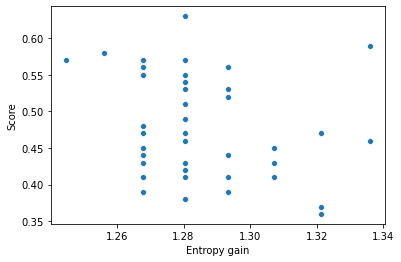

In [18]:
sns.scatterplot(x=[e for _, e, _ in results], y=[s for _, _, s in results])
plt.xlabel('Entropy gain')
plt.ylabel('Score')